In this notebook, we are going to see the stability of linear models with
- $u$
- $u, sf, cw$
- $u \cdot sf$  

under the control of 
- old control
- new control

In [57]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import MultipleLocator
import os.path
from pathlib import Path
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from qbo1d import utils
from qbo1d import adsolver
from qbo1d import emulate
from qbo1d.stochastic_forcing import WaveSpectrum

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from qbo1d.stochastic_forcing import sample_sf_cw


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Old control

## Data generator

In [58]:
# data generator:
def data_generator(state=1):
    '''
    Input: state(0~4)
    STATE = 0 -> old control
    STATE = 1 -> new control
    STATE = 2 -> different mean
    STATE = 3 -> different variance
    STATE = 4 -> anti-correlation(non-physical) 

    Output: (u, s, sf, cw, solver)
    '''

    # parameter dicts
    sfe = [3.7e-3, 3.8e-3, 3.2e-3, 3.8e-3, 3.8e-3]
    sfv = [1e-8, 9e-8, 9e-8, 9e-10, 9e-8]
    cwe = [32, 32, 40, 32, 32]
    cwv = [225, 225, 225, 225, 225]
    corr = [0.75, 0.75, 0.75, 0.75, -0.75]
    seed = [int(21*9+8), int(21*9+7), int(21*6+15), int(21*12+5), int(21*2+10)]

    # generate the matrix form

    para_mat = np.array([sfe, sfv, cwe, cwv, corr, seed]).T


    # Load the data manually
    # it takes 40 seconds

    t_max = 360 * 108 * 86400
    nsteps = 360 * 108
    nspinup = 360 * 12
    ntot = int(nsteps - nspinup)

    torch.set_default_dtype(torch.float64)


    # scenario 0 (control)
    # --------------------
    solver = adsolver.ADSolver(t_max=t_max, w=3e-4)
    model = WaveSpectrum(solver, *para_mat[state])
    time = solver.time
    z = solver.z
    u = solver.solve(source_func=model)

    return u, model.s, model.sf, model.cw, solver

In [59]:
STATE = 0
u, s, sf, cw, solver = data_generator(state=STATE)

In [60]:
nsteps = 360 * 108
nspinup = 360 * 12

u = u[nspinup:nsteps, :]
s = s[nspinup:nsteps, :] 
sf = sf[nspinup:nsteps]
cw = cw[nspinup:nsteps]

U_0 = u

U_1 = torch.hstack([u, sf.view(-1, 1), cw.view(-1, 1)])

U_2 = torch.diag(sf) @ u

# Here U is the features and s is the label

U_train_0, U_test_0, s_train_0, s_test_0 = train_test_split(U_0, s, test_size=0.2, random_state=42)
U_train_1, U_test_1, s_train_1, s_test_1 = train_test_split(U_1, s, test_size=0.2, random_state=42)
U_train_2, U_test_2, s_train_2, s_test_2 = train_test_split(U_2, s, test_size=0.2, random_state=42)

## Training

In [61]:
reg_0 = LinearRegression().fit(U_train_0, s_train_0)
reg_1 = LinearRegression().fit(U_train_1, s_train_1)
reg_2 = LinearRegression().fit(U_train_2, s_train_2)

## Online

In [62]:
torch.set_default_dtype(torch.float64)

# We set the tmax a little bit longer
# the default is 360*96*86400
# now we set it to 360*96
solver_ML = adsolver.ADSolver(t_max=3*360*96*86400, w=3e-4)

# Set up the linear model to pass in the PDE

sf_ML, cw_ML = sample_sf_cw(solver_ML.time.shape[0], sfe=3.7e-3, sfv=1e-8, cwe=32, cwv=225, corr=0.75, seed=int(21*9+8))


# u
model_ML_0 = lambda x : torch.tensor(reg_0.coef_) @ x + torch.tensor(reg_0.intercept_)


u_ML_0 = solver_ML.solve(source_func=model_ML_0)
u_ML_0 = u_ML_0.detach()



# u, sf, cw
solver_ML = adsolver.ADSolver(t_max=3*360*96*86400, w=3e-4)
model_ML_1 = lambda x : torch.tensor(reg_1.coef_) @ torch.hstack([x, sf_ML[solver_ML.current_step], cw_ML[solver_ML.current_step]]) + torch.tensor(reg_1.intercept_)


u_ML_1 = solver_ML.solve(source_func=model_ML_1)
u_ML_1 = u_ML_0.detach()

# u \cdot sf

solver_ML = adsolver.ADSolver(t_max=3*360*96*86400, w=3e-4)

model_ML_2 = lambda x : torch.tensor(reg_2.coef_) @ (sf_ML[solver_ML.current_step]*x) + torch.tensor(reg_2.intercept_)


u_ML_2 = solver_ML.solve(source_func=model_ML_2)
u_ML_2 = u_ML_2.detach()



Text(0, 0.5, 'zonal wind at z=35')

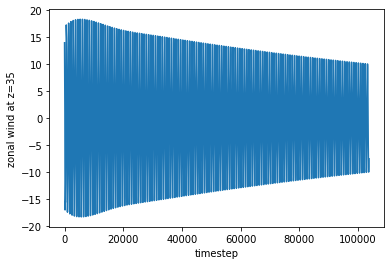

In [63]:
plt.plot(u_ML_0[:, 35])
plt.xlabel('timestep')
plt.ylabel('zonal wind at z=35')

No handles with labels found to put in legend.


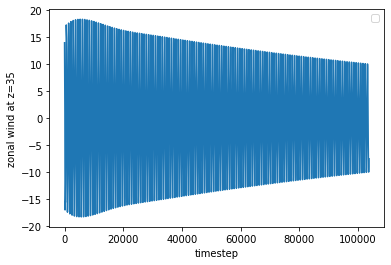

In [64]:
plt.plot(u_ML_1[:, 35])
plt.xlabel('timestep')
plt.ylabel('zonal wind at z=35')
plt.legend()

No handles with labels found to put in legend.


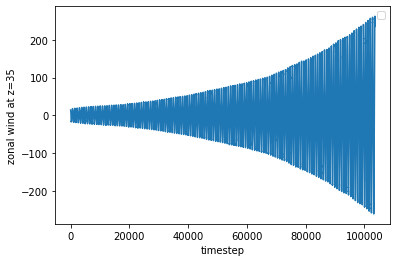

In [65]:
plt.plot(u_ML_2[:, 35])
plt.xlabel('timestep')
plt.ylabel('zonal wind at z=35')
plt.legend()

# New Control

In [66]:
STATE = 1
u, s, sf, cw, solver = data_generator(state=STATE)

In [67]:
nsteps = 360 * 108
nspinup = 360 * 12

u = u[nspinup:nsteps, :]
s = s[nspinup:nsteps, :] 
sf = sf[nspinup:nsteps]
cw = cw[nspinup:nsteps]

U_0 = u

U_1 = torch.hstack([u, sf.view(-1, 1), cw.view(-1, 1)])

U_2 = torch.diag(sf) @ u

# Here U is the features and s is the label

U_train_0, U_test_0, s_train_0, s_test_0 = train_test_split(U_0, s, test_size=0.2, random_state=42)
U_train_1, U_test_1, s_train_1, s_test_1 = train_test_split(U_1, s, test_size=0.2, random_state=42)
U_train_2, U_test_2, s_train_2, s_test_2 = train_test_split(U_2, s, test_size=0.2, random_state=42)

## Training

In [68]:
reg_0 = LinearRegression().fit(U_train_0, s_train_0)
reg_1 = LinearRegression().fit(U_train_1, s_train_1)
reg_2 = LinearRegression().fit(U_train_2, s_train_2)

## Online

In [69]:
torch.set_default_dtype(torch.float64)

# We set the tmax a little bit longer
# the default is 360*96*86400
# now we set it to 360*96
solver_ML = adsolver.ADSolver(t_max=3*360*96*86400, w=3e-4)

# Set up the linear model to pass in the PDE

new_control = [3.80e-03, 1.00e-08, 3.20e+01, 2.25e+02, 7.50e-01, 1.96e+02]

sf_ML, cw_ML = sample_sf_cw(solver_ML.time.shape[0], *new_control)

# u
model_ML_0 = lambda x : torch.tensor(reg_0.coef_) @ x + torch.tensor(reg_0.intercept_)


u_ML_0 = solver_ML.solve(source_func=model_ML_0)
u_ML_0 = u_ML_0.detach()



# u, sf, cw
solver_ML = adsolver.ADSolver(t_max=3*360*96*86400, w=3e-4)
model_ML_1 = lambda x : torch.tensor(reg_1.coef_) @ torch.hstack([x, sf_ML[solver_ML.current_step], cw_ML[solver_ML.current_step]]) + torch.tensor(reg_1.intercept_)


u_ML_1 = solver_ML.solve(source_func=model_ML_1)
u_ML_1 = u_ML_0.detach()

# u \cdot sf

solver_ML = adsolver.ADSolver(t_max=3*360*96*86400, w=3e-4)

model_ML_2 = lambda x : torch.tensor(reg_2.coef_) @ (sf_ML[solver_ML.current_step]*x) + torch.tensor(reg_2.intercept_)


u_ML_2 = solver_ML.solve(source_func=model_ML_2)
u_ML_2 = u_ML_2.detach()


Text(0, 0.5, 'zonal wind at z=35')

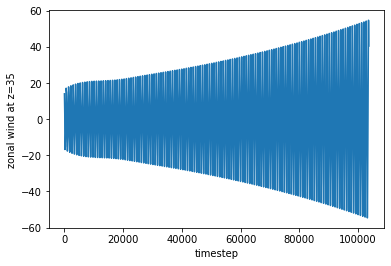

In [70]:
plt.plot(u_ML_0[:, 35])
plt.xlabel('timestep')
plt.ylabel('zonal wind at z=35')

Text(0, 0.5, 'zonal wind at z=35')

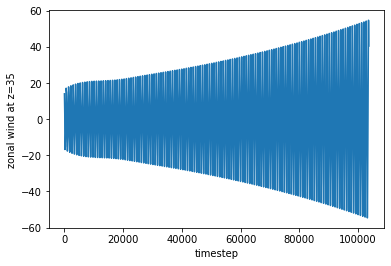

In [71]:
plt.plot(u_ML_1[:, 35])
plt.xlabel('timestep')
plt.ylabel('zonal wind at z=35')

Text(0, 0.5, 'zonal wind at z=35')

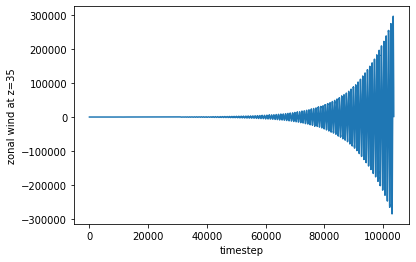

In [72]:
plt.plot(u_ML_2[:, 35])
plt.xlabel('timestep')
plt.ylabel('zonal wind at z=35')